Inspiration
In an aging society, medicare has becoming inceasingly vital. Unfortunately, with modern US Healthcare programs’ complexity and sophistication, fraud losses in healthcare cost US taxpayers a staggering amount...

Goals
Through informatics lens, explore the Medicare Part D prescribing data that was released through the CMS data portal at https://data.cms.gov/resource/77gb-8z53, and Medicare Exclusion list from the Office of Inspector General. Detect patterns of fraud medicare providers. Determine which prescribers prescribe most closely as fraud medicare providers by computing a distance matrix based on the total claims. 

.......

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import glob, os, csv
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly
#import addfips
from scipy.stats import f_oneway, spearmanr
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='acopolu', api_key='pZftHO47ZmReCjxlwDUB')

In [2]:
# download and import data Medicare Part D prescribing data that was released 
# through the CMS data portal at https://data.cms.gov/resource/77gb-8z53, 
# Medicare Exclusion list from the Office of Inspector General https://oig.hhs.gov/exclusions/exclusions_list.asp

part_d_df = pd.read_csv('data/part_d_2017.csv', low_memory=False)
exclusion_df = pd.read_csv('data/exclusion_list.csv', low_memory=False)
print("The data has a size of {}".format(part_d_df.shape))

The data has a size of (25209130, 21)


In [3]:
# reorganize data columns
part_d_df = part_d_df[['npi', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'description_flag',\
                        'drug_name', 'generic_name', 'bene_count', 'total_claim_count','total_day_supply', \
                        'total_drug_cost', 'bene_count_ge65', 'total_claim_count_ge65', 'total_day_supply_ge65',\
                        'total_drug_cost_ge65']]

# assigning exclusion (False = 0, True = 1)
exclusion_npi = exclusion_df['NPI'][exclusion_df['NPI'] != 0].values.tolist()
part_d_df['is_excluded'] = 0
#num_excluded = len(part_d_df.loc[part_d_df['npi'].isin(exclusion_npi)])
part_d_df.loc[part_d_df['npi'].isin(exclusion_npi), 'is_excluded'] = 1

# get US data to analyze
states = ['AK', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', \
          'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', \
          'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', \
          'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', \
          'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI',' WY']

#part_d_df = part_d_df[['npi', 'nppes_provider_city', 'nppes_provider_state', 'specialty_description', \
#                      'drug_name', 'total_claim_count', 'total_day_supply', 'total_drug_cost', 'is_excluded']]
part_d_df = part_d_df[part_d_df['nppes_provider_state'].isin(states)]

print("The data has a size of {}".format(part_d_df.shape))

The data has a size of (24792693, 16)


In [4]:
# Top 10 states which has the most prescribers
part_d_df_state_count = part_d_df.groupby('nppes_provider_state').count().sort_values('npi', ascending=False).iloc[0:10]
part_d_df_state_count

,npi,nppes_provider_city,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
nppes_provider_state,,,,,,,,,,,,,,,
CA,2394317,2394317,2394317,2394317,2394317,2394317,977922,2394317,2394317,2394317,356280,1402539,1402539,1402539,2394317
NY,1715994,1715994,1715994,1715994,1715994,1715994,645161,1715994,1715994,1715994,234138,1011727,1011727,1011727,1715994
FL,1686023,1686023,1686023,1686023,1686023,1686023,782607,1686023,1686023,1686023,251922,932495,932495,932495,1686023
TX,1575213,1575213,1575213,1575213,1575213,1575213,686140,1575213,1575213,1575213,211645,856767,856767,856767,1575213
PA,1271317,1271317,1271317,1271317,1271317,1271317,478076,1271317,1271317,1271317,167489,749255,749255,749255,1271317
OH,1047087,1047087,1047087,1047087,1047087,1047087,424678,1047087,1047087,1047087,147586,598394,598394,598394,1047087
IL,901698,901698,901698,901698,901698,901698,346009,901698,901698,901698,121411,523932,523932,523932,901698
NC,899910,899910,899910,899910,899910,899910,361322,899910,899910,899910,118741,503543,503543,503543,899910
MI,882556,882556,882556,882556,882556,882556,364086,882556,882556,882556,122075,472565,472565,472565,882556


In [5]:
# exclusion and non-exclusion prescribers
prescribers = part_d_df.groupby('is_excluded').count().sort_values('npi', ascending=False).iloc[0:2]
prescribers

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
is_excluded,,,,,,,,,,,,,,,
0,24783773,24783773,24783773,24783773,24783773,24783773,24783773,9904639,24783773,24783773,24783773,3424834,14075493,14075493,14075493
1,8920,8920,8920,8920,8920,8920,8920,3444,8920,8920,8920,1338,4881,4881,4881


In [172]:
# export exclusion providers data to do statistics analysis, run once when needed by uncommenting two lines below
part_d_df_exclusion = part_d_df[part_d_df['is_excluded'] == 1]
part_d_df_exclusion.to_csv('exclusion2017.csv')

In [7]:
len(part_d_df_exclusion['npi'].unique())

235

In [186]:
part_d_df.loc[part_d_df['npi'] == 1598714784].head(2)

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine
23816,1598714784,WEST PATERSON,NJ,Internal Medicine,S,CARBAMAZEPINE ER,CARBAMAZEPINE,NaN,12,360,1068.30,0.0,0.0,0.0,0.00,1,0
63511,1598714784,WEST PATERSON,NJ,Internal Medicine,S,VENTOLIN HFA,ALBUTEROL SULFATE,77.0,322,9239,18735.25,45.0,186.0,4925.0,10648.59,1,0


In [180]:
top_npi_drug_price = part_d_df_exclusion.groupby('npi').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_npi_drug_price.head(10)

,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine
npi,,,,,,,,,,
1205023512,2083.0,4538,126304,6598386.76,920.0,1907.0,52934.0,2553064.31,23,1
1285673012,403.0,1549,45842,3664224.25,20.0,473.0,13391.0,2911372.11,47,0
1871571406,2387.0,8306,393957,3416990.38,615.0,4532.0,226851.0,1161174.16,160,0
1598714784,4909.0,26951,908018,3292199.18,2030.0,16695.0,580702.0,1801728.38,299,1
1841322104,1769.0,14961,446595,2735336.14,389.0,4089.0,120554.0,435596.36,118,0
1982607370,4607.0,19462,767642,2156155.86,1798.0,11688.0,487907.0,945207.93,276,1
1063497600,63.0,912,30018,1594828.53,0.0,67.0,2130.0,104172.86,44,1
1881638781,2303.0,15243,617450,1072965.78,638.0,9405.0,421764.0,521681.15,223,0
1770542151,3214.0,10932,516270,1021210.26,1018.0,5863.0,268382.0,473565.15,178,0


In [176]:
top_npi_drug_count = part_d_df_exclusion.groupby('npi').count().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_npi_drug_count.head(10)

,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine
npi,,,,,,,,,,,,,,,,
1598714784,299,299,299,299,299,299,144,299,299,299,60,217,217,217,299,299
1982607370,276,276,276,276,276,276,127,276,276,276,40,167,167,167,276,276
1881638781,223,223,223,223,223,223,78,223,223,223,27,150,150,150,223,223
1891803318,218,218,218,218,218,218,80,218,218,218,23,128,128,128,218,218
1417008756,203,203,203,203,203,203,71,203,203,203,14,128,128,128,203,203
1730264854,199,199,199,199,199,199,67,199,199,199,17,143,143,143,199,199
1932162245,192,192,192,192,192,192,107,192,192,192,39,105,105,105,192,192
1770542151,178,178,178,178,178,178,88,178,178,178,19,81,81,81,178,178
1770625238,175,175,175,175,175,175,99,175,175,175,42,88,88,88,175,175


In [8]:
len(part_d_df_exclusion['drug_name'].unique())

728

In [9]:
len(part_d_df_exclusion['specialty_description'].unique())

39

In [10]:
part_d_df_exclusion['specialty_description'].unique()

array(['Internal Medicine', 'Neurology', 'Psychiatry', 'Anesthesiology',
       'Pain Management', 'Family Practice', 'Nurse Practitioner',
       'Hematology-Oncology', 'General Practice', 'Geriatric Medicine',
       'Urology', 'Cardiology', 'Emergency Medicine', 'Dentist',
       'Physical Medicine and Rehabilitation', 'Obstetrics & Gynecology',
       'Pediatric Medicine', 'Interventional Cardiology',
       'Interventional Pain Management', 'Physician Assistant',
       'Diagnostic Radiology', 'Podiatry', 'Specialist',
       'Clinical Cardiac Electrophysiology', 'Orthopedic Surgery',
       'Psychiatry & Neurology', 'Optometry', 'Otolaryngology',
       'General Surgery', 'Orthopaedic Surgery', 'Radiation Oncology',
       'Dermatology',
       'Student in an Organized Health Care Education/Training Program',
       'Gastroenterology', 'Certified Clinical Nurse Specialist',
       'Neurosurgery', 'Ophthalmology', 'Surgery',
       'Plastic and Reconstructive Surgery'], dtype=obje

Import into MSSQL Server to do analysis:
-- Exclusion provider state distribution: 
nppes_provider_state	state_cnt
AL	246
MI	240
PA	223
FL	161
TN	104
MA	103
CA	54
KS	29
NY	25
TX	8
-- Exclusion provider specialty distribution:
specialty_description	specialty_cnt
Internal Medicine	604
Nurse Practitioner	200
Family Practice	179
Geriatric Medicine	94
Cardiology	61
Physician Assistant	30
Pediatric Medicine	12
Podiatry	10
Orthopedic Surgery	3
-- Exclusion provider drug preference:
drug_name	drug_cnt
ALPRAZOLAM	12
AMLODIPINE BESYLATE	13
ATORVASTATIN CALCIUM	11
CLOPIDOGREL	11
GABAPENTIN	12
LEVOTHYROXINE SODIUM	13
LISINOPRIL	11
METOPROLOL SUCCINATE	12
OMEPRAZOLE	12
SIMVASTATIN	11

After full US dataset analysis, will use MI data to do detailed analysis

In [11]:
# some basic statistics
part_d_df.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
0,1861409989,METHUEN,MA,Internal Medicine,S,LOSARTAN-HYDROCHLOROTHIAZIDE,LOSARTAN/HYDROCHLOROTHIAZIDE,19.0,58,4920,1055.68,NaN,NaN,NaN,NaN,0
1,1073543153,GOOSE CREEK,SC,Family Practice,S,BUPROPION XL,BUPROPION HCL,NaN,41,2550,2348.88,NaN,NaN,NaN,NaN,0
2,1902845423,TAMPA,FL,General Practice,S,FAMOTIDINE,FAMOTIDINE,13.0,30,1270,216.59,NaN,NaN,NaN,NaN,0
3,1285749762,OAKLAND,CA,Internal Medicine,S,ATORVASTATIN CALCIUM,ATORVASTATIN CALCIUM,25.0,102,6093,1989.99,NaN,NaN,NaN,NaN,0
4,1275559288,ROWLAND HEIGHTS,CA,Internal Medicine,S,LYRICA,PREGABALIN,17.0,71,2180,35138.18,17.0,71.0,2180.0,35138.18,0


In [12]:
description = part_d_df.drop(['npi'], axis=1).describe()
drug_cost = part_d_df.total_drug_cost.sum()
n_providers = len(part_d_df['npi'].unique())
n_drugs = len(part_d_df['drug_name'].unique())
description

,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
count,9.908083e+06,2.479269e+07,2.479269e+07,2.479269e+07,3.426172e+06,1.408037e+07,1.408037e+07,1.408037e+07,2.479269e+07
mean,2.909582e+01,5.112438e+01,2.247030e+03,4.620560e+03,2.151781e+01,4.868468e+01,2.261344e+03,3.925217e+03,3.597834e-04
std,3.345899e+01,8.803478e+01,4.235207e+03,2.924885e+04,4.213172e+01,9.003833e+01,4.457076e+03,2.355397e+04,1.896455e-02
min,1.100000e+01,1.100000e+01,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,1.500000e+01,4.500000e+02,2.445200e+02,0.000000e+00,1.300000e+01,4.000000e+02,2.015300e+02,0.000000e+00
50%,2.000000e+01,2.400000e+01,9.600000e+02,6.453300e+02,1.400000e+01,2.100000e+01,9.230000e+02,5.849100e+02,0.000000e+00
75%,3.300000e+01,5.000000e+01,2.156000e+03,2.185490e+03,2.500000e+01,4.700000e+01,2.085000e+03,1.996260e+03,0.000000e+00
max,2.189300e+04,2.191300e+04,3.750090e+05,1.388153e+07,1.973000e+04,1.974600e+04,3.718170e+05,8.166394e+06,1.000000e+00


In [13]:
# summary
print('In full US dataset, there are {} observations in the dataset. These account to a total of ${:.0f} \
of drug sold from {} unique providers with {} unique drugs.'.format(len(part_d_df), drug_cost, n_providers,
                                                                           n_drugs))

In full US dataset, there are 24792693 observations in the dataset. These account to a total of $114556135403 of drug sold from 904999 unique providers with 2807 unique drugs.


In [14]:
# top selling drugs
top_drug_price = part_d_df.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_count = part_d_df.groupby('drug_name').count().sort_values('total_drug_cost', ascending=False).iloc[0:10]
top_drug_price.head(10)

,npi,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
drug_name,,,,,,,,,,
REVLIMID,9361110198083,18462.0,237850,6330212,3.031400e+09,4365.0,151581.0,4038310.0,1.919825e+09,1
ELIQUIS,157918216414782,844142.0,5691266,215996133,2.748870e+09,284167.0,3540175.0,133427633.0,1.697520e+09,28
JANUVIA,156047655024143,488168.0,4341276,191060988,2.458513e+09,95510.0,2427263.0,105484150.0,1.354597e+09,43
LANTUS SOLOSTAR,169463919964863,702964.0,4672166,211646954,2.354230e+09,135707.0,2304545.0,105850404.0,1.129403e+09,41
XARELTO,155739907647197,555938.0,4563464,174652258,2.242734e+09,169815.0,2725486.0,103744384.0,1.330405e+09,29
LYRICA,168886052716711,512452.0,4422688,144119793,2.162048e+09,79645.0,1778791.0,57539228.0,8.351656e+08,56
ADVAIR DISKUS,178636176474945,577089.0,4246261,166213035,2.062272e+09,100668.0,2075393.0,81943732.0,1.010256e+09,48
HUMIRA PEN,14791929567509,15024.0,313648,9404047,1.689801e+09,1464.0,133447.0,4080686.0,7.066294e+08,0
HARVONI,3155553106258,8340.0,46708,1298511,1.436756e+09,1131.0,10310.0,283740.0,3.069736e+08,0


In [15]:
# plotting use top ten drugs by price and amount
trace_price = go.Bar(x=top_drug_price.index, y=top_drug_price['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(000,000,102)', width=1.5)),
                     opacity = 0.8)
                     
trace_count = go.Bar(x=top_drug_count.index, y=top_drug_count['total_drug_cost'], name='by amount', 
                     marker=dict(color='rgb(241,250,248)', line=dict(color='rgb(13,129,106)', width=1.5)),
                     opacity = 0.8)
data = [trace_price, trace_count]

updatemenus = list([
    dict(
        buttons=list([
            dict(label = 'by price',
                method = 'update',
                args = [{'visible': [True, False]},
                         {'title': 'Top 10 Drugs in Medicare (By Price)'}]),
            dict(label = 'by amount',
                method = 'update',
                args = [{'visible': [False, True]},
                        {'title': 'Top 10 Drugs in Medicare (By Amount)'}])
        ]),
        direction = 'down',
        pad = {'r': 10, 't': 10},
        showactive = True,
        x = .8,
        xanchor = 'left',
        y = 1.1,
        yanchor = 'top' )
    
])
layout = dict(title='Top 10 Drugs in Medicare (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=10, pad=4),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='drug_dropdown')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~acopolu/0 or inside your plot.ly account where it is named 'drug_dropdown'


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [16]:
# Top 10 drugs sold by excluded providers
excluded_providers = part_d_df.loc[part_d_df['is_excluded'] == 1]
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:10]

# Plotting
trace_ex_price = go.Bar(x=excluded_drug_rank.index, y=excluded_drug_rank['total_drug_cost'], name='by price', 
                     marker=dict(color='rgb(255,204,204)', line=dict(color='rgb(204,000,000)', width=1.5)),
                     opacity = 0.8)  
data = [trace_ex_price]
layout = dict(title='Top 10 Drugs in Medicare Sold by Excluded Providers (By Price)', showlegend=False, 
              margin=go.Margin(l=50, r=100, b=120, t=50, pad=4))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='drug_excluded')

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [17]:
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False).iloc[0:20]
excluded_drug_rank.reset_index(level=["drug_name"], inplace=True)
exclusion_drug=excluded_drug_rank['drug_name'].values.tolist()
exclusion_drug

['DOXEPIN HCL',
 'LIDOCAINE',
 'OXYCONTIN',
 'RITUXAN',
 'LYRICA',
 'FLUOCINONIDE',
 'JANUVIA',
 'DICLOFENAC SODIUM',
 'SUBSYS',
 'SAIZEN',
 'REMICADE',
 'LANTUS SOLOSTAR',
 'ADVAIR DISKUS',
 'JAKAFI',
 'OMEPRAZOLE-SODIUM BICARBONATE',
 'XARELTO',
 'JANUMET',
 'TRADJENTA',
 'SYMBICORT',
 'SUBOXONE']

In [18]:
excluded_drug_cnt_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_claim_count', ascending=False).iloc[0:10]
excluded_drug_cnt_rank.head()

,npi,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
drug_name,,,,,,,,,,
ATORVASTATIN CALCIUM,146884334146,3615.0,14285,730010,225229.30,1734.0,10135.0,533133.0,167482.55,99
AMLODIPINE BESYLATE,146928760735,3387.0,13636,662993,77491.16,1446.0,8566.0,416589.0,50528.35,100
GABAPENTIN,181095257525,3456.0,12790,468472,217056.43,1196.0,5863.0,222349.0,91382.55,122
HYDROCODONE-ACETAMINOPHEN,121872160330,3309.0,11969,314438,242476.22,1168.0,4862.0,125663.0,101884.86,79
LEVOTHYROXINE SODIUM,144093994811,2561.0,11748,592168,225426.18,1119.0,8281.0,428402.0,161024.06,95


In [156]:
# select one drug and find alternatives to form a pool to explore drug selling statistics of exclusion providers
# select specific class medication and assign drug class flag (False = 0, True = 1)
excluded_drug_rank = excluded_providers.groupby('drug_name').sum().sort_values('total_drug_cost', ascending=False)
specific_medication =  [x.upper() for x in ['DOXEPIN HCL','DOXEPIN','Sinequan','Amitriptyline','Remeron','Klonopin','Seroquel','Ambien']]
part_d_df['is_amlodipine'] = 0
part_d_df.loc[part_d_df['drug_name'].isin(specific_medication), 'is_amlodipine'] = 1

In [157]:
excluded_drug_rank.reset_index(level=["drug_name"], inplace=True)
exclusion_drug=excluded_drug_rank['drug_name'].values.tolist()
#exclusion_drug

In [158]:
behavior = part_d_df[['total_claim_count', 'total_drug_cost', 'total_day_supply', \
               'is_excluded', 'is_amlodipine']].groupby(['is_excluded', 'is_amlodipine']).mean()
behavior

total_claim_count  total_drug_cost  \
is_excluded is_amlodipine                                       
0           0                      51.155878      4616.662046   
            1                      26.057381      7464.797923   
1           0                      51.262614      5106.916515   
            1                     107.285714    168437.211905   

                           total_day_supply  
is_excluded is_amlodipine                    
0           0                   2248.839146  
            1                    886.622760  
1           0                   1980.938308  
            1                   3250.047619

In [159]:
#  plotting
data = [{'x': ['Non-excluded Providers', 'Non-excluded Providers ', \
            'Excluded Providers', 'Excluded Providers '],
        'y': behavior['total_drug_cost'].values.tolist(),
        'text': ['Average total amount per beneficiary: {0:.0f}'.format(i) 
                 for i in behavior['total_claim_count'].values.tolist()],
        'mode': 'markers',
        'marker': {
            'color': ['rgb(051,153,255)', 'rgb(255,102,102)', 'rgb(000,051,153)', 'rgb(204,000,000)'],
            'size': behavior['total_claim_count'].values.tolist(),
            'showscale': False
        }
    }
]

annotations=[dict(x='Non-excluded Providers', y=10000, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Non-excluded Providers ', y=22500, xref='x', yref='y', text='Amlodipine', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers', y=10500, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers ', y=68000, xref='x', yref='y', text='Amlodipine',\
                  showarrow=True, arrowhead=7, ax=0, ay=-40)]

layout = dict(title='Medicare Prescription Cost and Amount by Excluded and Non-excluded Providers', showlegend=False, 
              annotations=annotations, margin=go.Margin(l=50, r=100, b=120, t=50, pad=4), 
              yaxis=dict(title='Average Cost Per Beneficiary ($)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='provider-behavior')

In [160]:
# Explore specialties of excluded providers
nonexcluded_providers = part_d_df[part_d_df['is_excluded'] == 0]
nonexcluded_providers_specialty = nonexcluded_providers.groupby \
('specialty_description').count().sort_values('npi', ascending=False).head()/len(nonexcluded_providers)*100
nonexcluded_providers_specialty = nonexcluded_providers_specialty['npi'].to_dict()

excluded_providers_specialty = excluded_providers.groupby \
('specialty_description').count().sort_values('npi', ascending=False).head()/len(excluded_providers)*100
excluded_providers_specialty = excluded_providers_specialty['npi'].to_dict()

for i, j in zip(list(nonexcluded_providers_specialty.keys()), list(excluded_providers_specialty.keys())):
    if i not in excluded_providers_specialty.keys():
        excluded_providers_specialty.update({i: 0})
    if j not in nonexcluded_providers_specialty.keys():
        nonexcluded_providers_specialty.update({j: 0})

nonex_ex_specialty = pd.DataFrame(0, index=excluded_providers_specialty.keys(), columns=['nonexcluded', 'excluded'])
nonex_ex_specialty.loc[:, 'nonexcluded'] = pd.Series(nonexcluded_providers_specialty)
nonex_ex_specialty.loc[:, 'excluded'] = pd.Series(excluded_providers_specialty)
nonex_ex_specialty.loc['Others'] = list(100 - nonex_ex_specialty.sum().values)
nonex_ex_specialty

,nonexcluded,excluded
Internal Medicine,26.068569,44.910314
Family Practice,28.378395,22.230942
Nurse Practitioner,12.597226,5.011211
Geriatric Medicine,0.000000,4.428251
Cardiology,3.288571,3.295964
Physician Assistant,5.743895,0.000000
Others,23.923343,20.123318


In [161]:
# analyze specialty statistics of fraud providers
le = LabelEncoder()
specialty = le.fit_transform(part_d_df['specialty_description'])
labels = part_d_df['is_excluded'].values.tolist()

corr, p = spearmanr(specialty, labels)

print('The Spearman\' correlation between providers\' specialty and whether the provider is fraud is {:.4f} \
with a p-value of {:.4f}.'.format(corr, p))

The Spearman' correlation between providers' specialty and whether the provider is fraud is -0.0020 with a p-value of 0.0000.


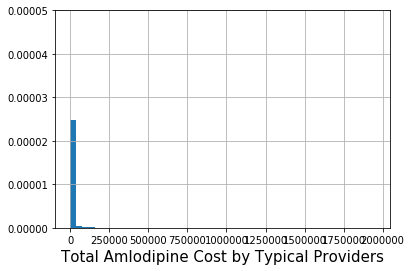

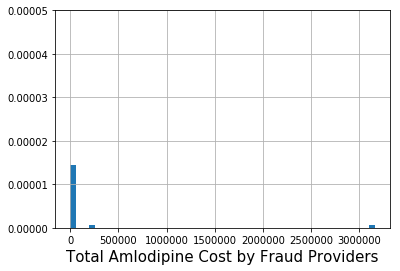

In [163]:
# sales behavior difference between typical and fraud providers
amlodipine_by_fraud = part_d_df[(part_d_df['is_excluded'] == 1) & (part_d_df['is_amlodipine'] == 1)]
amlodipine_by_typical = part_d_df[(part_d_df['is_excluded'] == 0) & (part_d_df['is_amlodipine'] == 1)]
all_by_fraud = part_d_df[(part_d_df['is_excluded'] == 1)]
all_by_typical = part_d_df[(part_d_df['is_excluded'] == 0)]

amlodipine_by_typical.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Amlodipine Cost by Typical Providers', fontsize=15)
plt.savefig('amlodipine_by_typical.jpeg', dpi=1000)
plt.ylim([0, 0.00005])
plt.show()
amlodipine_by_fraud.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Amlodipine Cost by Fraud Providers', fontsize=15)
plt.savefig('amlodipine_by_fraud.jpeg', dpi=1000)
plt.ylim([0, 0.00005])
plt.show()

The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value of 0.7126, therefore, we do NOT reject the hypothesis.
The null hypothesis that fraud providers sell amlodipine with the same total cost as typical provider has a p-value of 0.0000, therefore, we REJECT the hypothesis.


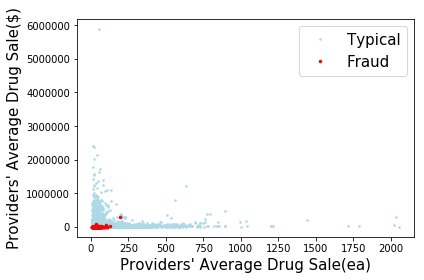

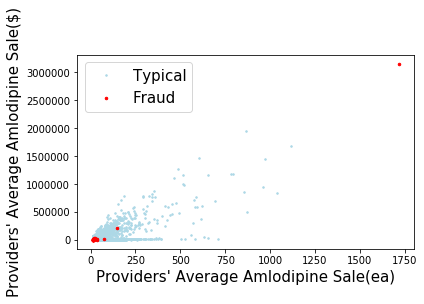

In [164]:
# amlodipine selling statistics of fraud and typical providers
fraud_providers_n = part_d_df[(part_d_df['is_excluded'] == 1) & (part_d_df['is_amlodipine'] ==1)].groupby(['npi']).mean()
typical_providers_n = part_d_df[(part_d_df['is_excluded'] == 0) & (part_d_df['is_amlodipine'] ==1)].groupby(['npi']).mean()

cost_typical_n = typical_providers_n['total_drug_cost']
cost_fraud_n = fraud_providers_n['total_drug_cost']
amount_typical_n = typical_providers_n['total_claim_count']
amount_fraud_n = fraud_providers_n['total_claim_count']

# All drugs selling statistics of fraud and typical providers
fraud_providers_d = part_d_df[(part_d_df['is_excluded'] == 1)].groupby(['npi']).mean()
typical_providers_d = part_d_df[(part_d_df['is_excluded'] == 0)].groupby(['npi']).mean()

cost_typical_d = typical_providers_d['total_drug_cost']
cost_fraud_d = fraud_providers_d['total_drug_cost']
amount_typical_d = typical_providers_d['total_claim_count']
amount_fraud_d = fraud_providers_d['total_claim_count']

print('The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we do NOT reject the hypothesis.'.format(f_oneway(cost_typical_d, cost_fraud_d)[1]))

print('The null hypothesis that fraud providers sell amlodipine with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we REJECT the hypothesis.'.format(f_oneway(cost_typical_n, cost_fraud_n)[1]))


plt.plot(amount_typical_d, cost_typical_d, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_d, cost_fraud_d, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Drug Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Drug Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_d.jpeg', dpi=1000)plt.show()

plt.plot(amount_typical_n, cost_typical_n, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_n, cost_fraud_n, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Amlodipine Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Amlodipine Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_n.jpeg', dpi=1000)
plt.show()

Choose state dataset to do detailed analyses. The criteria of choosing state is based on exclusion data analyses, top state, top drug, and top npi counts

In [187]:
part_d_df_small=part_d_df[part_d_df['nppes_provider_state']=='NJ']

In [188]:
len(part_d_df_small)

663531

In [167]:
# exclusion and non-exclusion prescribers
prescribers = part_d_df_small.groupby('is_excluded').count().sort_values('npi', ascending=False).iloc[0:2]
prescribers

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_amlodipine
is_excluded,,,,,,,,,,,,,,,,
0,882036,882036,882036,882036,882036,882036,882036,363883,882036,882036,882036,121967,472312,472312,472312,882036
1,520,520,520,520,520,520,520,203,520,520,520,108,253,253,253,520


In [168]:
description = part_d_df_small.drop(['npi'], axis=1).describe()
drug_cost = part_d_df_small.total_drug_cost.sum()
n_providers = len(part_d_df_small['npi'].unique())
n_drugs = len(part_d_df_small['drug_name'].unique())
description

,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine
count,364086.000000,882556.000000,882556.000000,8.825560e+05,122075.000000,472565.000000,472565.000000,4.725650e+05,882556.000000,882556.000000
mean,28.447098,49.008203,2296.779452,4.583850e+03,20.473119,45.985896,2317.465274,3.896214e+03,0.000589,0.000936
std,29.748141,78.387731,4130.250220,3.174517e+04,36.619517,79.016307,4411.924646,2.679816e+04,0.024266,0.030578
min,11.000000,11.000000,11.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,14.000000,15.000000,483.000000,2.267100e+02,0.000000,13.000000,420.000000,1.805100e+02,0.000000,0.000000
50%,19.000000,24.000000,1020.000000,5.961900e+02,13.000000,21.000000,990.000000,5.301100e+02,0.000000,0.000000
75%,32.000000,49.000000,2250.000000,1.978485e+03,24.000000,45.000000,2190.000000,1.761940e+03,0.000000,0.000000
max,4299.000000,4300.000000,257471.000000,7.058642e+06,3870.000000,3871.000000,234450.000000,4.503705e+06,1.000000,1.000000


In [169]:
# summary
print('In full US dataset, there are {} observations in the dataset. These account to a total of ${:.0f} \
of drug sold from {} unique providers with {} unique drugs.'.format(len(part_d_df_small), drug_cost, n_providers,
                                                                           n_drugs))

In full US dataset, there are 882556 observations in the dataset. These account to a total of $4045504692 of drug sold from 32931 unique providers with 1888 unique drugs.


In [170]:
behavior = part_d_df_small[['total_claim_count', 'total_drug_cost', 'total_day_supply', \
               'is_excluded', 'is_amlodipine']].groupby(['is_excluded', 'is_amlodipine']).mean()
behavior

total_claim_count  total_drug_cost  \
is_excluded is_amlodipine                                       
0           0                      49.033286      4586.176296   
            1                      24.832524      3544.999612   
1           0                      44.895753      2264.269614   
            1                      23.000000      8567.265000   

                           total_day_supply  
is_excluded is_amlodipine                    
0           0                   2298.658768  
            1                    860.174757  
1           0                   1391.181467  
            1                    690.000000

In [171]:
#  plotting
data = [{'x': ['Non-excluded Providers', 'Non-excluded Providers ', \
            'Excluded Providers', 'Excluded Providers '],
        'y': behavior['total_drug_cost'].values.tolist(),
        'text': ['Average total amount per beneficiary: {0:.0f}'.format(i) 
                 for i in behavior['total_claim_count'].values.tolist()],
        'mode': 'markers',
        'marker': {
            'color': ['rgb(051,153,255)', 'rgb(255,102,102)', 'rgb(000,051,153)', 'rgb(204,000,000)'],
            'size': behavior['total_claim_count'].values.tolist(),
            'showscale': False
        }
    }
]

annotations=[dict(x='Non-excluded Providers', y=10000, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Non-excluded Providers ', y=12500, xref='x', yref='y', text='Amlodipine', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers', y=10500, xref='x', yref='y', text='All Drugs', \
                  showarrow=True, arrowhead=7, ax=0, ay=-40),
             dict(x='Excluded Providers ', y=68000, xref='x', yref='y', text='Amlodipine',\
                  showarrow=True, arrowhead=7, ax=0, ay=-40)]

layout = dict(title='Medicare Prescription Cost and Amount by Excluded and Non-excluded Providers', showlegend=False, 
              annotations=annotations, margin=go.Margin(l=50, r=100, b=120, t=50, pad=4), 
              yaxis=dict(title='Average Cost Per Beneficiary ($)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='provider-behavior')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



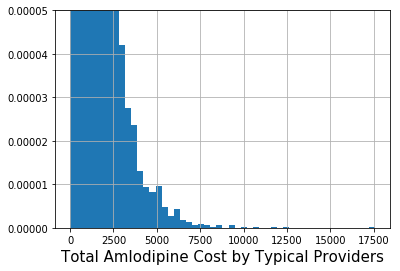

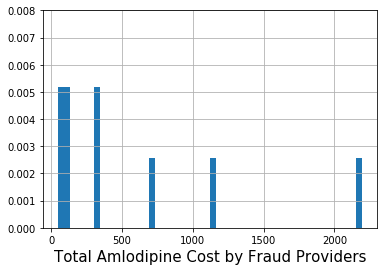

In [34]:
# sales behavior difference between typical and fraud providers
amlodipine_by_fraud = part_d_df_small[(part_d_df_small['is_excluded'] == 1) & (part_d_df_small['is_amlodipine'] == 1)]
amlodipine_by_typical = part_d_df_small[(part_d_df_small['is_excluded'] == 0) & (part_d_df_small['is_amlodipine'] == 1)]
all_by_fraud = part_d_df_small[(part_d_df_small['is_excluded'] == 1)]
all_by_typical = part_d_df_small[(part_d_df_small['is_excluded'] == 0)]

amlodipine_by_typical.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Amlodipine Cost by Typical Providers', fontsize=15)
plt.savefig('amlodipine_by_typical.jpeg', dpi=1000)
plt.ylim([0, 0.00005])
plt.show()
amlodipine_by_fraud.total_drug_cost.hist(bins=50, normed=True)
plt.xlabel('Total Amlodipine Cost by Fraud Providers', fontsize=15)
plt.savefig('amlodipine_by_fraud.jpeg', dpi=1000)
plt.ylim([0, 0.008])
plt.show()

The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value of 0.5608, therefore, we do NOT reject the hypothesis.
The null hypothesis that fraud providers sell amlodipine with the same total cost as typical provider has a p-value of 0.3326, therefore, we REJECT the hypothesis.


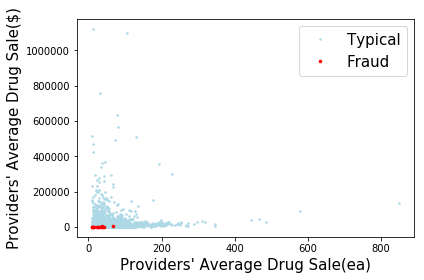

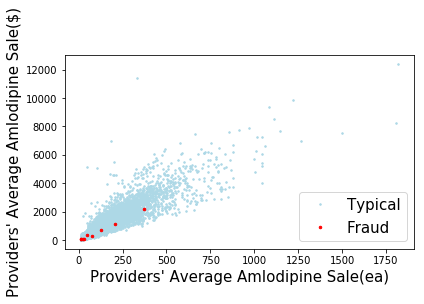

In [35]:
# amlodipine selling statistics of fraud and typical providers
fraud_providers_n = part_d_df_small[(part_d_df_small['is_excluded'] == 1) & (part_d_df_small['is_amlodipine'] ==1)].groupby(['npi']).mean()
typical_providers_n = part_d_df_small[(part_d_df_small['is_excluded'] == 0) & (part_d_df_small['is_amlodipine'] ==1)].groupby(['npi']).mean()

cost_typical_n = typical_providers_n['total_drug_cost']
cost_fraud_n = fraud_providers_n['total_drug_cost']
amount_typical_n = typical_providers_n['total_claim_count']
amount_fraud_n = fraud_providers_n['total_claim_count']

# All drugs selling statistics of fraud and typical providers
fraud_providers_d = part_d_df_small[(part_d_df_small['is_excluded'] == 1)].groupby(['npi']).mean()
typical_providers_d = part_d_df_small[(part_d_df_small['is_excluded'] == 0)].groupby(['npi']).mean()

cost_typical_d = typical_providers_d['total_drug_cost']
cost_fraud_d = fraud_providers_d['total_drug_cost']
amount_typical_d = typical_providers_d['total_claim_count']
amount_fraud_d = fraud_providers_d['total_claim_count']

print('The null hypothesis that fraud providers sell all drugs with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we do NOT reject the hypothesis.'.format(f_oneway(cost_typical_d, cost_fraud_d)[1]))

print('The null hypothesis that fraud providers sell amlodipine with the same total cost as typical provider has a p-value \
of {:.4f}, therefore, we REJECT the hypothesis.'.format(f_oneway(cost_typical_n, cost_fraud_n)[1]))


plt.plot(amount_typical_d, cost_typical_d, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_d, cost_fraud_d, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Drug Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Drug Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_d.jpeg', dpi=1000)
plt.show()

plt.plot(amount_typical_n, cost_typical_n, markersize=3, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(amount_fraud_n, cost_fraud_n, markersize=5, linestyle='none', marker='.', color='r', label='Fraud')
plt.xlabel('Providers\' Average Amlodipine Sale(ea)', fontsize=15)
plt.ylabel('Providers\' Average Amlodipine Sale($)', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('AmountVSCost_n.jpeg', dpi=1000)
plt.show()

In [36]:
# User pandas crosstab function to create a dataframe where each row is a prescriber identified by their NPI, 
# the columns are the drug names, the values are sum of total_claim_count.
npi_drug_cross_df = pd.crosstab(part_d_df_small["npi"], part_d_df_small["drug_name"], values=part_d_df_small["total_claim_count"], 
                                  aggfunc=np.sum)

In [37]:
npi_drug_cross_df.head()

drug_name,1ST TIER UNIFINE PENTIPS,1ST TIER UNIFINE PENTIPS PLUS,ABACAVIR,ABACAVIR-LAMIVUDINE,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACAMPROSATE CALCIUM,ACARBOSE,ACCOLATE,...,ZYCLARA,ZYDELIG,ZYFLO,ZYFLO CR,ZYLET,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
npi,,,,,,,,,,,,,,,,,,,,,
1003001884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003004326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003005315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003006503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003013392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# To replace the NaN (not a number) from the cells with zero the fillna() method is used.
npi_drug_cross_df = npi_drug_cross_df.fillna(0)

In [39]:
npi_drug_cross_df.head()

drug_name,1ST TIER UNIFINE PENTIPS,1ST TIER UNIFINE PENTIPS PLUS,ABACAVIR,ABACAVIR-LAMIVUDINE,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,ABILIFY MAINTENA,ACAMPROSATE CALCIUM,ACARBOSE,ACCOLATE,...,ZYCLARA,ZYDELIG,ZYFLO,ZYFLO CR,ZYLET,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
npi,,,,,,,,,,,,,,,,,,,,,
1003001884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003004326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003005315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003006503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003013392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# add a new field called drug_count to the dataframe
part_d_df_small["drug_count"] = 1

# use the groupby() and agg() methods to create a new dataframe. use numpy sum method to populate values
prescriber_specialty_df = part_d_df_small.groupby(["npi","specialty_description"]).agg({"total_claim_count": np.sum,  "drug_count": np.sum})

In [41]:
prescriber_specialty_df.head()

,,total_claim_count,drug_count
npi,specialty_description,,
1003001884,Family Practice,2333,69
1003004326,Orthopaedic Surgery,13,1
1003005315,Plastic and Reconstructive Surgery,312,5
1003006503,Internal Medicine,2020,58
1003013392,Urology,1012,21


In [42]:
# to merge the tables we need to flatten the indices.
prescriber_specialty_df.reset_index(level=["npi","specialty_description"], inplace=True)

In [43]:
prescriber_specialty_df.head()

,npi,specialty_description,total_claim_count,drug_count
0,1003001884,Family Practice,2333,69
1,1003004326,Orthopaedic Surgery,13,1
2,1003005315,Plastic and Reconstructive Surgery,312,5
3,1003006503,Internal Medicine,2020,58
4,1003013392,Urology,1012,21


In [44]:
# use npi to merge two tables prescriber_specialty_df and npi_drug_cross_df
prescriber_specialty_drugs_df = pd.merge(prescriber_specialty_df, npi_drug_cross_df.reset_index(level=["npi"]), on="npi")

In [45]:
prescriber_specialty_drugs_df.head()

,npi,specialty_description,total_claim_count,drug_count,1ST TIER UNIFINE PENTIPS,1ST TIER UNIFINE PENTIPS PLUS,ABACAVIR,ABACAVIR-LAMIVUDINE,ABACAVIR-LAMIVUDINE-ZIDOVUDINE,ABILIFY,...,ZYCLARA,ZYDELIG,ZYFLO,ZYFLO CR,ZYLET,ZYPREXA,ZYPREXA RELPREVV,ZYPREXA ZYDIS,ZYTIGA,ZYVOX
0,1003001884,Family Practice,2333,69,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003004326,Orthopaedic Surgery,13,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003005315,Plastic and Reconstructive Surgery,312,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003006503,Internal Medicine,2020,58,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003013392,Urology,1012,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Start classification models

from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from scipy.stats import pointbiserialr

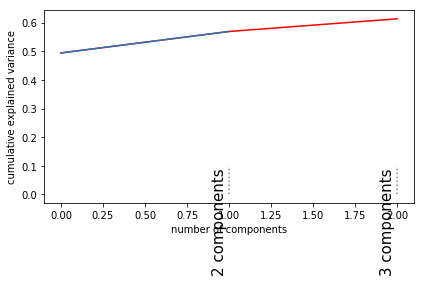

In [47]:
# Applying PCA (2 components), but we will plot both 3 and 2 components for visualization of vairance explained

pca = decomposition.PCA(n_components=3)
pca.fit(npi_drug_cross_df)
npi_drug_df_transformed = pca.transform(npi_drug_cross_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='r')

pca = decomposition.PCA(n_components=2)
pca.fit(npi_drug_cross_df)
npi_drug_cross_df_transformed = pca.transform(npi_drug_cross_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.vlines(1, color='grey', ymax=0.1, ymin=0, linestyle=':')
plt.vlines(2, color='grey', ymax=0.1, ymin=0, linestyle=':')

plt.annotate('2 components', xy=(0.6, 0.05), xytext=(0.9, 0.05), fontsize=15, rotation=90)
plt.annotate('3 components', xy=(1.6, 0.05), xytext=(1.9, 0.05), fontsize=15, rotation=90)

plt.savefig('VarExp.jpeg', dpi=1000)
plt.tight_layout()
plt.show()

In [121]:
part_d_df_small.head()

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine,drug_count
18,1679868053,BAD AXE,MI,Family Practice,S,ESCITALOPRAM OXALATE,ESCITALOPRAM OXALATE,NaN,38,2400,472.29,NaN,16.0,1080.0,142.98,0,0,1
50,1699790626,ROSEVILLE,MI,Internal Medicine,S,SPIRONOLACTONE,SPIRONOLACTONE,NaN,22,1860,341.46,NaN,22.0,1860.0,341.46,0,0,1
66,1508837626,TAYLOR,MI,General Practice,S,SYMBICORT,BUDESONIDE/FORMOTEROL FUMARATE,NaN,34,1020,10462.55,NaN,NaN,NaN,NaN,0,0,1
67,1396712055,LIVONIA,MI,Family Practice,S,LISINOPRIL,LISINOPRIL,21.0,80,5104,289.46,NaN,69.0,4410.0,262.80,0,0,1
79,1710989546,FLINT,MI,Internal Medicine,S,TIMOLOL MALEATE,TIMOLOL MALEATE,NaN,12,535,91.96,NaN,12.0,535.0,91.96,0,0,1


In [48]:
npi_group = part_d_df_small.groupby('npi').sum()
print("There are {} unique providers".format(len(npi_group)))

There are 32931 unique providers


In [127]:
npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
df = pd.concat([pd.DataFrame(npi_drug_cross_df_transformed, index=npi_label.index), npi_label], axis=1)

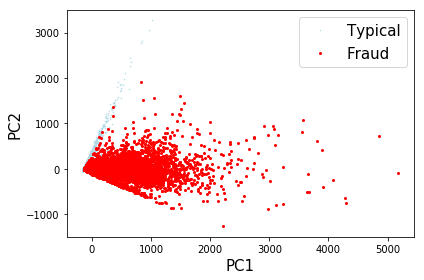

In [128]:

df_fraud = df[df['is_excluded'] == 1]
df_typical = df[df['is_excluded'] == 0]

plt.plot(df[0].values.tolist(), df[1].values.tolist(), \
        markersize=1, linestyle='none', marker='.', color='lightblue', label='Typical')
plt.plot(df_amlodipine[0].values.tolist(), df_amlodipine[1].values.tolist(), \
        markersize=4, linestyle='none', marker='.', color='r', label='Fraud')

plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('PC2.jpeg', dpi=1000)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



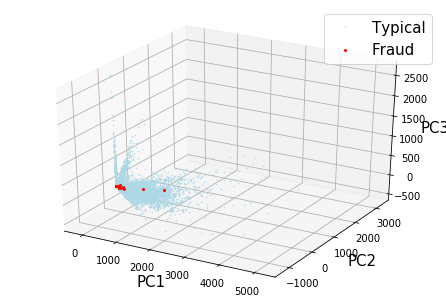

In [129]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

pca = decomposition.PCA(n_components=3)
pca.fit(npi_drug_cross_df)
npi_drug_cross_df_transformed = pca.transform(npi_drug_cross_df)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
#plt.show()

npi_label = pd.DataFrame(npi_group['is_excluded'].apply(lambda x: 1 if x > 0  else 0))
df = pd.concat([pd.DataFrame(npi_drug_cross_df_transformed, index=npi_label.index), npi_label], axis=1)

df_amlodipine = df[df['is_excluded'] == 1]

ax.plot(df[0].values.tolist(), df[1].values.tolist(), df[2].values.tolist(), \
        markersize=1, linestyle='none', marker='.', color='lightblue', label='Typical')
ax.plot(df_amlodipine[0].values.tolist(), df_amlodipine[1].values.tolist(), df_amlodipine[2].values.tolist(), \
        markersize=4, linestyle='none', marker='.', color='r', label='Fraud')

ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_zlabel('PC3', fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()
fig.savefig('PC3.jpeg', dpi=1000)
plt.show()

In [151]:
# Below is the training without up and down sampling

In [130]:
X = df.drop(['is_excluded'], axis=1)
y = df['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [131]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.999988662645685


array([[22051,     0],
       [    1,    11]], dtype=int64)

In [132]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.4947998159226875


array([[10865,     0],
       [    3,     0]], dtype=int64)

In [152]:
# Below is the training with up sampling

In [133]:
# Upsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    32916
1     5480
Name: is_excluded, dtype: int64

In [134]:
X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [135]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.9999908904169963


array([[22063,     6],
       [    0,  3656]], dtype=int64)

In [136]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.9999942885816921


array([[10845,     2],
       [    0,  1824]], dtype=int64)

In [153]:
# Below is the training with down sampling

In [138]:
# Downsampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_majority_downsampled = resample(df_majority, replace=True, n_samples=48670, random_state=42) # Reduce by 10 times
df_downsampled = pd.concat([df_majority_downsampled, df_minority]) 
df_downsampled['is_excluded'].value_counts()

0    48670
1       15
Name: is_excluded, dtype: int64

In [139]:
X = df_downsampled.drop(['is_excluded'], axis=1)
y = df_downsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [140]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.9999860598811744


array([[32607,     0],
       [    1,    10]], dtype=int64)

In [141]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.49769656975658344


array([[16063,     0],
       [    4,     0]], dtype=int64)

In [154]:
# Below is the training with up and down sampling

In [142]:
# Downsampling+Upsampling
df_updownsampled = pd.concat([df_majority_downsampled, df_minority_upsampled]) 
df_updownsampled['is_excluded'].value_counts()

0    48670
1     5480
Name: is_excluded, dtype: int64

In [143]:
X = df_updownsampled.drop(['is_excluded'], axis=1)
y = df_updownsampled['is_excluded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [144]:
y_pred = clf.predict(X_train)
y_pred_prob = clf.predict_proba(X_train)
print(roc_auc_score(y_train, y_pred_prob[:,1]))
confusion_matrix(y_train, y_pred)

0.9999920757823156


array([[32621,     8],
       [    0,  3651]], dtype=int64)

In [145]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_prob[:,1]))
confusion_matrix(y_test, y_pred)

0.9999896042770935


array([[16036,     5],
       [    0,  1829]], dtype=int64)

In [155]:
# In conclusion, results from just upsampling only is the best.
# Below is classification models comparison

In [146]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

seed = 42

In [147]:
# Use up sampling
df_majority = df[df['is_excluded'] == 0]
df_minority = df[df['is_excluded'] > 0]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=5480, random_state=42) # Increase by 10 times
df_upsampled = pd.concat([df_majority, df_minority_upsampled])  
df_upsampled['is_excluded'].value_counts()

0    32916
1     5480
Name: is_excluded, dtype: int64

In [148]:
df_upsampled.head()

,0,1,2,is_excluded
npi,,,,
1003001884,184.988381,-68.911274,11.149299,0
1003004326,-143.572987,-12.053362,-7.984827,0
1003005315,-110.450593,82.433181,-29.125541,0
1003006503,91.309158,-24.611479,-18.912319,0
1003013392,-103.340409,34.209881,-11.069348,0


In [150]:
# Identifying the best model algorithm
colors = ["#08306b", "#08519c", "#1361a9", "#4292c6", "#6baed6", 'rgb(76,000,153)', 'rgb(153,000,153)']

X = df_upsampled.drop(['is_excluded'], axis=1)
y = df_upsampled['is_excluded']

scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'}

names = ["Naive Bayes", "Nearest Neighbors", "RBF SVM", 
         "AdaBoost", "GradientBoost", "ExtraTrees", "Random Forest"]
        
classifiers = [
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="rbf", C=1, probability=True),
    AdaBoostClassifier(n_estimators=50, random_state=seed),
    GradientBoostingClassifier(n_estimators=1000, random_state=seed),
    ExtraTreesClassifier(n_estimators=50, random_state=seed),
    RandomForestClassifier(n_estimators=50, random_state=seed),]

trace_dict = {}
# iterate over classifiers
for color, name, clf in tqdm_notebook(zip(colors, names, classifiers), total=len(names)):
    cv_results = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
    print('########################### \nFor {}'.format(name))
    for score in scoring:
        print('{0:s}: Mean-{1:.4f}  STD-{2:.4f}'.format(score, cv_results['test_'+score].mean(),\
                                                        cv_results['test_'+score].std()))
    trace_dict.update({'trace' + name: go.Bar(x=name, y=cv_results['test_F1'].mean(), error_y=dict(type='data',
                                              array=np.std(cv_results['test_F1']),visible=True),
                                              name=name, marker=dict(color=color), showlegend=False)})


layout = go.Layout(
    title='Performance of Different Models by F1 Score',
    #width=500,
    xaxis=dict(autorange=True, showgrid=False, zeroline=False, showline=False, autotick=True, ticks='',
               showticklabels=True),
    yaxis=dict(title='F1 Score', zeroline=False),
    margin=go.Margin(l=50, r=65, b=100, t=60, pad=4))

data = [trace_dict[trace] for trace in trace_dict]
fig= go.Figure(data=data, layout=layout)
py.iplot(fig, filename='F1models')

########################### 
For Naive Bayes
AUC: Mean-0.6128  STD-0.0055
Accuracy: Mean-0.8491  STD-0.0035
F1: Mean-0.0436  STD-0.0534



ValueError: 
    Invalid value of type 'numpy.float64' received for the 'array' property of bar.error_y
        Received value: 0.053358684478261705

    The 'array' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

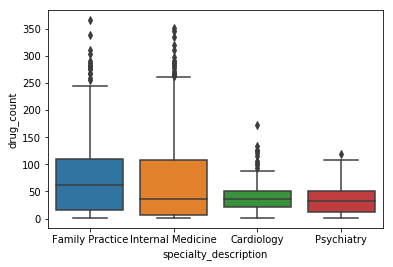

In [54]:
# show that different medical specialties prescribe different numbers of drugs
import seaborn as sb
%matplotlib inline

sb.boxplot(x="specialty_description", y="drug_count", 
           data=prescriber_specialty_drugs_df
           [(prescriber_specialty_drugs_df["specialty_description"] == "Cardiology") |
           (prescriber_specialty_drugs_df["specialty_description"] == "Internal Medicine") |
           (prescriber_specialty_drugs_df["specialty_description"] == "Family Practice") |
           (prescriber_specialty_drugs_df["specialty_description"] == "Psychiatry")]
          )

Build the dataframes and corresponding matrices to compute the euclidean distance between two Medicare prescribers in AL. Creating a crosstab by using "generic_name". For example the branded drug Abilify has the generic name of ARIPiprazole. A great tool for understanding the relationship between active ingredients, generic name and branded product is RxNav (https://rxnav.nlm.nih.gov/)

In [55]:
# User pandas crosstab function to create a dataframe where each row is a prescriber identified by their NPI, 
# the columns are the drug generic names, the values are the sum of total_claim_count
npi_generic_cross_df = pd.crosstab(part_d_df_small["npi"], part_d_df_small["generic_name"], values=part_d_df_small["total_claim_count"], 
                                  aggfunc=np.sum)

In [56]:
# To replace the NaN (not a number) from the cells with zero the fillna() method is used.
npi_generic_cross_df = npi_generic_cross_df.fillna(0)

In [57]:
npi_generic_cross_df.head()

generic_name,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/DOLUTEGRAVIR/LAMIVUDI,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABALOPARATIDE,ABATACEPT,ABATACEPT/MALTOSE,ABIRATERONE ACETATE,ACAMPROSATE CALCIUM,...,ZALEPLON,ZIDOVUDINE,ZILEUTON,ZIPRASIDONE HCL,ZIPRASIDONE MESYLATE,ZOLEDRONIC ACID/MANNITOL-WATER,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
npi,,,,,,,,,,,,,,,,,,,,,
1003001884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003004326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003005315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003006503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0
1003013392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# use npi to merge two tables prescriber_specialty_df and npi_generic_cross_df
prescriber_specialty_generic_df = pd.merge(prescriber_specialty_df, npi_generic_cross_df.reset_index(level=["npi"]), on="npi")

In [59]:
prescriber_specialty_generic_df.head()

,npi,specialty_description,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/DOLUTEGRAVIR/LAMIVUDI,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABALOPARATIDE,...,ZALEPLON,ZIDOVUDINE,ZILEUTON,ZIPRASIDONE HCL,ZIPRASIDONE MESYLATE,ZOLEDRONIC ACID/MANNITOL-WATER,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
0,1003001884,Family Practice,2333,69,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003004326,Orthopaedic Surgery,13,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003005315,Plastic and Reconstructive Surgery,312,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003006503,Internal Medicine,2020,58,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0
4,1003013392,Urology,1012,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
prescriber_specialty_generic_df = prescriber_specialty_generic_df.sort_values(by=["specialty_description", "npi"])

In [61]:
prescriber_specialty_generic_df.head()

,npi,specialty_description,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/DOLUTEGRAVIR/LAMIVUDI,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABALOPARATIDE,...,ZALEPLON,ZIDOVUDINE,ZILEUTON,ZIPRASIDONE HCL,ZIPRASIDONE MESYLATE,ZOLEDRONIC ACID/MANNITOL-WATER,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
1287,1033434253,Addiction Medicine,46,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3298,1093934267,Addiction Medicine,38,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4199,1124374244,Addiction Medicine,325,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5125,1154509172,Addiction Medicine,69,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6688,1205098803,Addiction Medicine,221,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Since the data has been resorted by specialty_desc and npi, index needs to be updated to reflect new order of data
prescriber_specialty_generic_df=prescriber_specialty_generic_df.reset_index(drop=True)
prescriber_specialty_generic_df.head()

,npi,specialty_description,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/DOLUTEGRAVIR/LAMIVUDI,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABALOPARATIDE,...,ZALEPLON,ZIDOVUDINE,ZILEUTON,ZIPRASIDONE HCL,ZIPRASIDONE MESYLATE,ZOLEDRONIC ACID/MANNITOL-WATER,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
0,1033434253,Addiction Medicine,46,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1093934267,Addiction Medicine,38,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1124374244,Addiction Medicine,325,15,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1154509172,Addiction Medicine,69,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1205098803,Addiction Medicine,221,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Based on analyzed result, the interested excluded npi is 1982706941
# we need to find out the position of 1982706941 based on this script, the result is 17368
# update the position of the rest of the scripts using 17368
prescriber_specialty_generic_df.loc[prescriber_specialty_generic_df['npi'] == 1982706941]

,npi,specialty_description,total_claim_count,drug_count,0.9 % SODIUM CHLORIDE,ABACAVIR SULFATE,ABACAVIR SULFATE/LAMIVUDINE,ABACAVIR/DOLUTEGRAVIR/LAMIVUDI,ABACAVIR/LAMIVUDINE/ZIDOVUDINE,ABALOPARATIDE,...,ZALEPLON,ZIDOVUDINE,ZILEUTON,ZIPRASIDONE HCL,ZIPRASIDONE MESYLATE,ZOLEDRONIC ACID/MANNITOL-WATER,ZOLMITRIPTAN,ZOLPIDEM TARTRATE,ZONISAMIDE,ZOSTER VACCINE LIVE/PF
17368,1982706941,Internal Medicine,1542,59,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0


Shift from using the Pandas dataframe object to the `numpy.array`. Slice off the columns that are not related to the number of filled prescriptions and convert this to a matrix. The `iloc()` method slices a dataframe by the column and the method `as_matrix()` converts the dataframe into a numpy array.

In [64]:
pf_matrix = prescriber_specialty_generic_df.iloc[: , 4: ].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [65]:
pf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
identifiers_matrix = prescriber_specialty_generic_df.iloc[:,0:2].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [67]:
generic_array = prescriber_specialty_generic_df.columns[4:]

In [68]:
generic_array

Index(['0.9 % SODIUM CHLORIDE', 'ABACAVIR SULFATE',
       'ABACAVIR SULFATE/LAMIVUDINE', 'ABACAVIR/DOLUTEGRAVIR/LAMIVUDI',
       'ABACAVIR/LAMIVUDINE/ZIDOVUDINE', 'ABALOPARATIDE', 'ABATACEPT',
       'ABATACEPT/MALTOSE', 'ABIRATERONE ACETATE', 'ACAMPROSATE CALCIUM',
       ...
       'ZALEPLON', 'ZIDOVUDINE', 'ZILEUTON', 'ZIPRASIDONE HCL',
       'ZIPRASIDONE MESYLATE', 'ZOLEDRONIC ACID/MANNITOL-WATER',
       'ZOLMITRIPTAN', 'ZOLPIDEM TARTRATE', 'ZONISAMIDE',
       'ZOSTER VACCINE LIVE/PF'],
      dtype='object', length=1186)

In [69]:
# to compute the distance between a vector representing the drugs that a prescriber prescribes 
# we need to import the scipy.spatial library.
import scipy.spatial

Normalize the claim count of prescriptions by the total number of claims for the prescriber. Each entry now represent the percentage of total claims that are associated with the prescriber.

In [70]:
np.reshape(np.sum(pf_matrix,1), (pf_matrix.shape[0],1))

array([[ 46.],
       [ 38.],
       [325.],
       ...,
       [374.],
       [215.],
       [205.]])

In [71]:
normalized_pf_matrix = pf_matrix / np.reshape(np.sum(pf_matrix,1), (pf_matrix.shape[0],1))

In [72]:
normalized_pf_matrix.shape

(32931, 1186)

Use the euclidean distance to compute the distance between two prescribers. The results of the pdist() function need to be placed into square form. 

In [73]:
prescriber_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(normalized_pf_matrix, "euclidean"))

In [74]:
prescriber_dist.shape

(32931, 32931)

As we have sorted the prescribers by their specialty then we expect to see some spatial patterns in the distance matrix. A matrix can be visualized using the `matplotlib` library.

In [73]:
import matplotlib.pyplot as plt

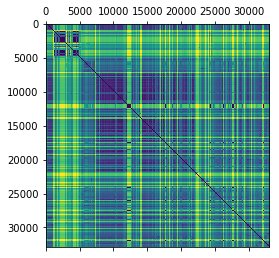

In [74]:
plt.matshow(prescriber_dist)

In [75]:
prescriber_specialty_generic_df.iloc[17368,0:4]

npi                             1982706941
specialty_description    Internal Medicine
total_claim_count                     1542
drug_count                              59
Name: 17368, dtype: object

In [76]:
# The prescriber referenced at position 17368 is an Internal Medicine. 
# We can now calculate the prescribers most similar to this Internal Medicine.
prescriber_dist[17368,:]

array([1.01298138, 0.74875454, 0.32032563, ..., 0.62761035, 0.56195061,
       0.53087094])

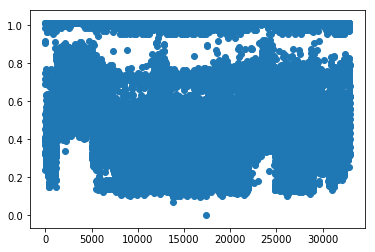

In [77]:
# plotting the distances we can see that prescribers most like are probably also Internal Medicine.
plt.scatter(np.arange(prescriber_dist.shape[0]),prescriber_dist[17368,:])

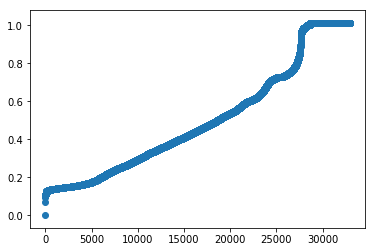

In [78]:
plt.scatter(np.arange(prescriber_dist.shape[0]),np.sort(prescriber_dist[17368,:]))

In [79]:
providers_sorted = np.lexsort((prescriber_dist[:,17368].tolist(),))

In [80]:
prescriber_specialty_generic_df.iloc[:,0:2].as_matrix()[providers_sorted[0:40],:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



array([[1982706941, 'Internal Medicine'],
       [1093817603, 'Internal Medicine'],
       [1841242245, 'Internal Medicine'],
       [1073675427, 'Internal Medicine'],
       [1134196645, 'Nurse Practitioner'],
       [1477513158, 'Internal Medicine'],
       [1134355944, 'Physician Assistant'],
       [1184790495, 'Internal Medicine'],
       [1417924309, 'Family Practice'],
       [1295722916, 'Internal Medicine'],
       [1679592877, 'Internal Medicine'],
       [1851399471, 'Internal Medicine'],
       [1992734214, 'Internal Medicine'],
       [1376593228, 'Family Practice'],
       [1881786770, 'Internal Medicine'],
       [1851585228, 'Nurse Practitioner'],
       [1649262353, 'Family Practice'],
       [1164657805, 'Family Practice'],
       [1831282706, 'Family Practice'],
       [1881899946, 'Internal Medicine'],
       [1447230941, 'Internal Medicine'],
       [1952377160, 'Internal Medicine'],
       [1730152216, 'Internal Medicine'],
       [1063820074, 'Nurse Practitioner'

In [81]:
np.lexsort(((-1 * pf_matrix[17368,:]).tolist(),))[0:17]

array([ 655,   24,  699, 1068,  642,  310,  825,  235,  400,  477,   12,
         87,  504,   42, 1016,  161,  490], dtype=int64)

In [82]:
generic_array[np.lexsort(((-1 * pf_matrix[17368,:]).tolist(),))][0:16]

Index(['LISINOPRIL', 'ALBUTEROL SULFATE', 'METFORMIN HCL', 'TAMSULOSIN HCL',
       'LIDOCAINE', 'DICLOFENAC SODIUM', 'OMEPRAZOLE', 'CLOPIDOGREL BISULFATE',
       'ESOMEPRAZOLE MAGNESIUM', 'FLUTICASONE/SALMETEROL',
       'ACETAMINOPHEN WITH CODEINE', 'ATORVASTATIN CALCIUM', 'GLIPIZIDE',
       'ALPRAZOLAM', 'SIMVASTATIN', 'CANAGLIFLOZIN'],
      dtype='object')

In [83]:
part_d_df_small[part_d_df_small["npi"]==1982706941].sort_values("total_claim_count", ascending=False)

,npi,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded,is_amlodipine,drug_count
16511548,1982706941,DEARBORN,MI,Internal Medicine,S,LISINOPRIL,LISINOPRIL,36.0,88,3180,301.92,16.0,46.0,1560.0,131.36,1,0,1
4108473,1982706941,DEARBORN,MI,Internal Medicine,S,VENTOLIN HFA,ALBUTEROL SULFATE,30.0,73,2099,3889.83,14.0,35.0,1023.0,1847.77,1,0,1
635839,1982706941,DEARBORN,MI,Internal Medicine,S,METFORMIN HCL,METFORMIN HCL,29.0,71,2490,260.93,13.0,32.0,1200.0,107.59,1,0,1
765124,1982706941,DEARBORN,MI,Internal Medicine,S,TAMSULOSIN HCL,TAMSULOSIN HCL,29.0,68,2640,1202.73,18.0,43.0,1710.0,861.86,1,0,1
7741319,1982706941,DEARBORN,MI,Internal Medicine,S,LIDOCAINE,LIDOCAINE,39.0,63,1890,10878.77,23.0,41.0,1230.0,7018.76,1,0,1
25107012,1982706941,DEARBORN,MI,Internal Medicine,S,OMEPRAZOLE,OMEPRAZOLE,29.0,57,2174,370.74,NaN,18.0,780.0,117.81,1,0,1
22003728,1982706941,DEARBORN,MI,Internal Medicine,S,CLOPIDOGREL,CLOPIDOGREL BISULFATE,24.0,54,2400,427.67,NaN,NaN,NaN,NaN,1,0,1
8898103,1982706941,DEARBORN,MI,Internal Medicine,S,ADVAIR DISKUS,FLUTICASONE/SALMETEROL,17.0,43,1290,16477.63,NaN,24.0,720.0,8683.60,1,0,1
14132582,1982706941,DEARBORN,MI,Internal Medicine,S,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE,22.0,41,1132,405.58,NaN,12.0,325.0,137.43,1,0,1
22458994,1982706941,DEARBORN,MI,Internal Medicine,S,ATORVASTATIN CALCIUM,ATORVASTATIN CALCIUM,20.0,38,1288,361.20,NaN,NaN,NaN,NaN,1,0,1


Based on top drugs and specialties from exclusoin list, use MI data to do fraud prediction

In [52]:
# select columns to form new dataset
part_d_df_small_ml = part_d_df_small[['npi', 'specialty_description', 'drug_name', 'total_claim_count',\
                        'total_day_supply','total_drug_cost','total_claim_count_ge65',\
                        'total_day_supply_ge65','total_drug_cost_ge65']]
part_d_df_small_ml.head()

,npi,specialty_description,drug_name,total_claim_count,total_day_supply,total_drug_cost,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
18,1679868053,Family Practice,ESCITALOPRAM OXALATE,38,2400,472.29,16.0,1080.0,142.98
50,1699790626,Internal Medicine,SPIRONOLACTONE,22,1860,341.46,22.0,1860.0,341.46
66,1508837626,General Practice,SYMBICORT,34,1020,10462.55,NaN,NaN,NaN
67,1396712055,Family Practice,LISINOPRIL,80,5104,289.46,69.0,4410.0,262.80
79,1710989546,Internal Medicine,TIMOLOL MALEATE,12,535,91.96,12.0,535.0,91.96


In [53]:
# choose top 20 drugs from exclusion list
exclusion_druglist=['DOXEPIN HCL','LIDOCAINE','OXYCONTIN','RITUXAN','LYRICA','FLUOCINONIDE','JANUVIA','DICLOFENAC SODIUM',\
'SUBSYS','SAIZEN','REMICADE','LANTUS SOLOSTAR','ADVAIR DISKUS','JAKAFI','OMEPRAZOLE-SODIUM BICARBONATE','XARELTO',\
'JANUMET','TRADJENTA','SYMBICORT','SUBOXONE']

In [54]:
# add a new column is_excludeddrug to indicate drugs from exclusion list
part_d_df_small_ml['is_excludeddrug'] = 0
part_d_df_small_ml.loc[part_d_df_small_ml['drug_name'].isin(exclusion_druglist), 'is_excludeddrug'] = 1
part_d_df_small_ml.head()

,npi,specialty_description,drug_name,total_claim_count,total_day_supply,total_drug_cost,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excludeddrug
18,1679868053,Family Practice,ESCITALOPRAM OXALATE,38,2400,472.29,16.0,1080.0,142.98,0
50,1699790626,Internal Medicine,SPIRONOLACTONE,22,1860,341.46,22.0,1860.0,341.46,0
66,1508837626,General Practice,SYMBICORT,34,1020,10462.55,NaN,NaN,NaN,1
67,1396712055,Family Practice,LISINOPRIL,80,5104,289.46,69.0,4410.0,262.80,0
79,1710989546,Internal Medicine,TIMOLOL MALEATE,12,535,91.96,12.0,535.0,91.96,0


In [55]:
# number of drugs in MI dataset for ML analysis
len(part_d_df_small_ml['drug_name'].unique())

1888

In [56]:
# number of drugs in MI dataset of exclusion list
len(part_d_df_exclusion['drug_name'].unique())

728

In [57]:
excluded_providers.groupby \
('specialty_description').count().sort_values('npi', ascending=False).head(10)

,npi,nppes_provider_city,nppes_provider_state,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_day_supply,total_drug_cost,bene_count_ge65,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excluded
specialty_description,,,,,,,,,,,,,,,
Internal Medicine,4006,4006,4006,4006,4006,4006,1561,4006,4006,4006,496,2245,2245,2245,4006
Family Practice,1983,1983,1983,1983,1983,1983,643,1983,1983,1983,291,1107,1107,1107,1983
Nurse Practitioner,447,447,447,447,447,447,171,447,447,447,75,209,209,209,447
Geriatric Medicine,395,395,395,395,395,395,166,395,395,395,59,238,238,238,395
Cardiology,294,294,294,294,294,294,147,294,294,294,40,161,161,161,294
Neurology,261,261,261,261,261,261,86,261,261,261,66,139,139,139,261
Anesthesiology,221,221,221,221,221,221,91,221,221,221,66,128,128,128,221
Hematology-Oncology,216,216,216,216,216,216,106,216,216,216,21,115,115,115,216
General Practice,122,122,122,122,122,122,34,122,122,122,19,80,80,80,122


In [58]:
# get subset of data related to specilties from exclusion list
specialties=['Internal Medicine','Nurse Practitioner','Family Practice','Geriatric Medicine',
'Cardiology','Physician Assistant','Pediatric Medicine','Podiatry','Orthopedic Surgery']
part_d_df_small_ml=part_d_df_small_ml.loc[part_d_df_small_ml['specialty_description'].isin(specialties)]

In [59]:
part_d_df_small_ml.head()

,npi,specialty_description,drug_name,total_claim_count,total_day_supply,total_drug_cost,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excludeddrug
18,1679868053,Family Practice,ESCITALOPRAM OXALATE,38,2400,472.29,16.0,1080.0,142.98,0
50,1699790626,Internal Medicine,SPIRONOLACTONE,22,1860,341.46,22.0,1860.0,341.46,0
67,1396712055,Family Practice,LISINOPRIL,80,5104,289.46,69.0,4410.0,262.80,0
79,1710989546,Internal Medicine,TIMOLOL MALEATE,12,535,91.96,12.0,535.0,91.96,0
86,1841244548,Family Practice,FUROSEMIDE,81,4480,269.97,61.0,3745.0,205.56,0


In [60]:
len(part_d_df_small_ml)

699850

In [61]:
len(part_d_df_small_ml[part_d_df_small_ml['is_excludeddrug']==1])

28994

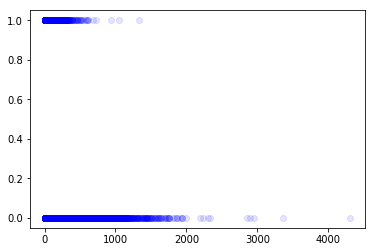

In [62]:
plt.plot(part_d_df_small_ml.total_claim_count, part_d_df_small_ml.is_excludeddrug, "bo",alpha=0.1)

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
lr = LogisticRegression()

In [65]:
part_d_df_small_ml.total_claim_count.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



array([38, 22, 80, ..., 21, 82, 13], dtype=int64)

In [66]:
part_d_df_small_ml.is_excludeddrug.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
claim = np.reshape(part_d_df_small_ml.total_claim_count.as_matrix(), (len(part_d_df_small_ml),1))
exclusion = np.reshape(part_d_df_small_ml.is_excludeddrug.as_matrix(), (len(part_d_df_small_ml),1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [68]:
claim.shape

(699850, 1)

In [69]:
lr_fit = lr.fit(claim, exclusion)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [70]:
b1 = lr_fit.coef_[0][0]
b1

-0.005558213076806975

In [71]:
b0 = lr_fit.intercept_[0]
b0

-2.9190697430649544

In [72]:
part_d_df_small_ml.total_claim_count.describe()

count    699850.000000
mean         48.664075
std          74.525730
min          11.000000
25%          15.000000
50%          24.000000
75%          49.000000
max        4300.000000
Name: total_claim_count, dtype: float64

In [73]:
steps = np.arange(0,4500,step=100)

In [74]:
prob_claim = lr_fit.predict_proba(np.reshape(steps, (len(steps),1)))
p_claim = prob_claim[:,1]

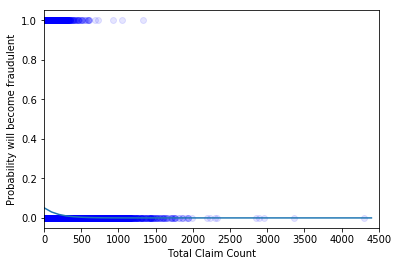

In [75]:
fig, axes = plt.subplots(1)
axes.set_xlim(0,4500)
axes.set_xlabel("Total Claim Count")
axes.set_ylabel("Probability will become fraudulent")
axes.plot(part_d_df_small_ml.total_claim_count, part_d_df_small_ml.is_excludeddrug, "bo",alpha=0.1)
axes.plot(steps, np.ravel(p_claim))

In [76]:
part_d_df_small_ml.describe()

,npi,total_claim_count,total_day_supply,total_drug_cost,total_claim_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,is_excludeddrug
count,6.998500e+05,699850.000000,699850.000000,6.998500e+05,378202.000000,378202.000000,3.782020e+05,699850.000000
mean,1.502652e+09,48.664075,2385.228753,3.120965e+03,46.794181,2424.333880,2.681928e+03,0.041429
std,2.901422e+08,74.525730,4078.529466,1.950251e+04,75.872058,4317.789028,1.629891e+04,0.199280
min,1.003002e+09,11.000000,11.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,1.245482e+09,15.000000,532.000000,2.357800e+02,13.000000,480.000000,2.015700e+02,0.000000
50%,1.508854e+09,24.000000,1080.000000,5.868050e+02,22.000000,1063.000000,5.424300e+02,0.000000
75%,1.750638e+09,49.000000,2370.000000,1.777978e+03,47.000000,2330.000000,1.658185e+03,0.000000
max,1.992998e+09,4300.000000,193819.000000,7.058642e+06,3871.000000,173914.000000,4.503705e+06,1.000000


In [77]:
feature_columns = ['total_claim_count','total_day_supply','total_drug_cost']
features_array = part_d_df_small_ml[feature_columns].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [78]:
features_array[0:2,:]

array([[  38.  , 2400.  ,  472.29],
       [  22.  , 1860.  ,  341.46]])

In [79]:
labels_to_predict_array = part_d_df_small_ml[["is_excludeddrug"]].as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(features_array, labels_to_predict_array, test_size=0.25)

In [82]:
X_train.shape, X_test.shape

((524887, 3), (174963, 3))

In [83]:
Y_train.shape, Y_test.shape

((524887, 1), (174963, 1))

In [84]:
lr_db = LogisticRegression(penalty="l1")

In [85]:
lr_db_fit = lr_db.fit(X_train, np.ravel(Y_train))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [86]:
lr_db_fit.coef_

array([[-4.04729161e-03, -1.88637090e-04,  4.93472673e-05]])

In [87]:
[(lr_db_fit.coef_[0,i], feature_columns[i]) for i in range(lr_db_fit.coef_.shape[1])]

[(-0.004047291608701616, 'total_claim_count'),
 (-0.0001886370901597459, 'total_day_supply'),
 (4.934726727421776e-05, 'total_drug_cost')]

In [88]:
Y_predicted = lr_db_fit.predict(X_test)
Y_predicted.sum(), Y_predicted.sum() / Y_predicted.shape[0]

(411, 0.002349068088681607)

In [89]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score 

In [90]:
confusion_matrix(Y_test, Y_predicted, labels=[1.0,0.0])

array([[    53,   7150],
       [   358, 167402]], dtype=int64)

In [91]:
{
    "accuracy": accuracy_score(Y_test, Y_predicted), 
    "recall": recall_score(Y_test, Y_predicted),
    "precision": precision_score(Y_test, Y_predicted),
    "f1": f1_score(Y_test, Y_predicted)
}

{'accuracy': 0.9570880700490961,
 'recall': 0.007358045258919895,
 'precision': 0.12895377128953772,
 'f1': 0.0139217231415813}

In [92]:
Y_predicted_p_raw = lr_db_fit.predict_proba(X_test)

In [93]:
Y_predicted_p_raw[0:5,:]

array([[0.96083223, 0.03916777],
       [0.94181925, 0.05818075],
       [0.99536172, 0.00463828],
       [0.95433215, 0.04566785],
       [0.9547826 , 0.0452174 ]])

In [94]:
Y_predicted_p = Y_predicted_p_raw[:,1]

In [95]:
auc = roc_auc_score(Y_test, Y_predicted_p)
auc

0.9357985095491195

In [96]:
data_roc_curve = roc_curve(Y_test, Y_predicted_p)

Text(0.6, 0.2, 'AUC=0.936')

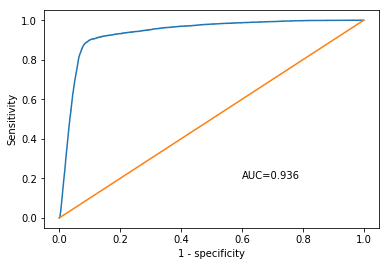

In [97]:
fig, axes = plt.subplots(1)
axes.plot(data_roc_curve[0],data_roc_curve[1])
axes.set_xlabel("1 - specificity")
axes.set_ylabel("Sensitivity")
axes.plot([0,1],[0,1])
axes.text(0.6, 0.2, "AUC=%.3f" % auc)

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
dct = DecisionTreeClassifier(max_depth=3)

In [100]:
dct_fit = dct.fit(X_train, Y_train)

In [101]:
tY_predicted = dct.predict(X_test)

In [102]:
confusion_matrix(Y_test, tY_predicted, labels=[1,0])

array([[     0,   7203],
       [     0, 167760]], dtype=int64)

In [103]:
{
    "accuracy": accuracy_score(Y_test, Y_predicted), 
    "recall": recall_score(Y_test, Y_predicted),
    "precision": precision_score(Y_test, Y_predicted),
    "f1": f1_score(Y_test, Y_predicted)
}

{'accuracy': 0.9570880700490961,
 'recall': 0.007358045258919895,
 'precision': 0.12895377128953772,
 'f1': 0.0139217231415813}

In [104]:
from sklearn import tree

In [105]:
import graphviz

In [106]:
dot_data = tree.export_graphviz(dct_fit, out_file=None, feature_names=feature_columns, filled=True) 

In [107]:
graph = graphviz.Source(dot_data) 

In [108]:
# output is under C:\Users\Wei Li\CSIREProj\health-open-data-workshop-master\fraud.pdf
graph.render("fraud")

'fraud.pdf'